<a href="https://colab.research.google.com/github/mvidales775/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Prediction of Product Sales </h1>
<ul>
Michael Vidales
</ul>

#Project Overview#


Link to the orginal dataset on Analytics Vidhya

https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/

<h2>Data Dictionary<h2>

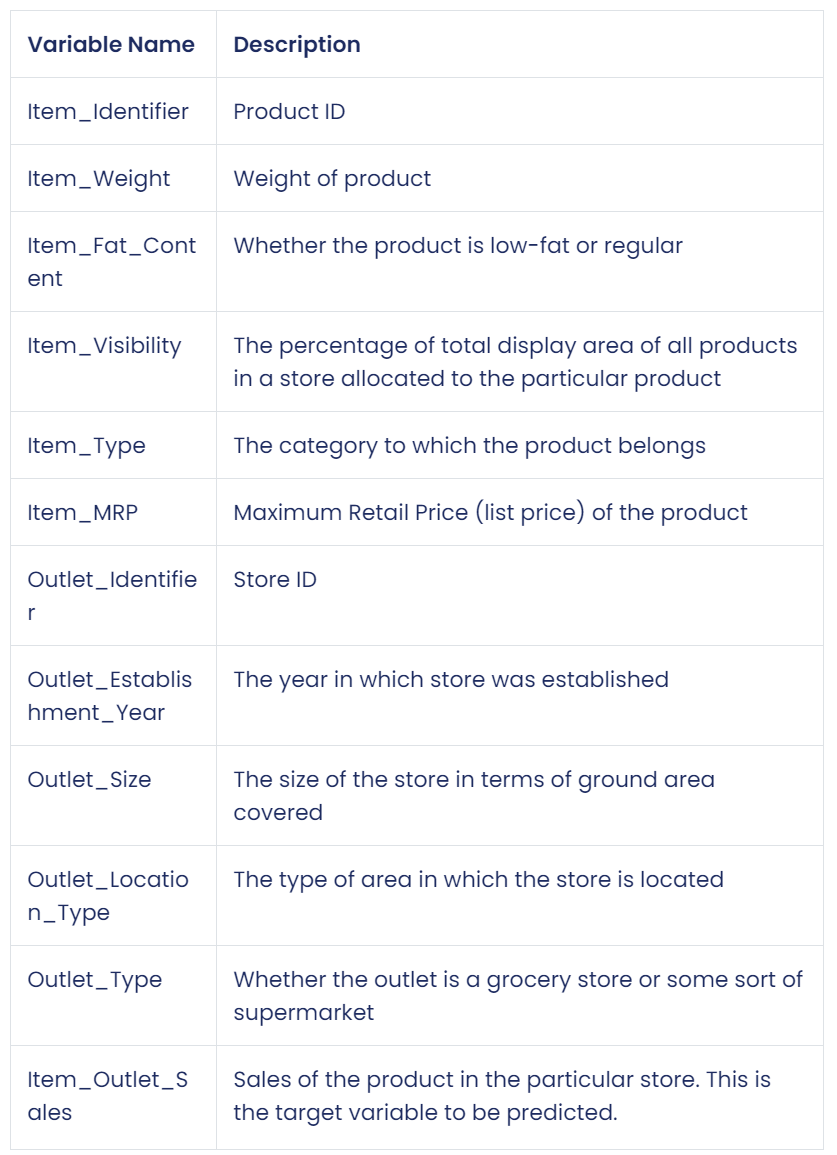

#Loading Data#

<h2>Imports</h2>

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')


In [42]:
sales_2023 = "/content/drive/MyDrive/CodingDojo/Project 1/sales_predictions_2023.csv"
df = pd.read_csv(sales_2023)

In [43]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


- Then use df.dtypes to view each columns datatype

In [44]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

#Cleaning Data#


<h2>Duplicates<h2>

- To clean the data we'll check for duplicates first

In [45]:
df.duplicated().sum()

0

- Since there are no duplicates we can find all of the null values

<h2>Missing Values<h2>

In [46]:
null_sums = df.isna().sum()
null_sums

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- Item_Weight has 1463 out 8523
- Outlet_Size has 2410 out 8523

In [47]:
null_percent = null_sums/len(df) * 100
null_percent[null_percent>0]

Item_Weight    17.165317
Outlet_Size    28.276428
dtype: float64

- Item_Weight is missing 17% of values and is numeric
  - Will use 'median' to fill null values since This is less affected by outliers than using 'mean'.


In [48]:
median_item_weight = df['Item_Weight'].median()
df['Item_Weight'].fillna(value = median_item_weight, inplace = True)

- Outlet_Size is missing 28% of values and is categorical
  - Will replace null values with "UNKNOWN" since there is not enough missing to justify droping and this will not create bias in favour of a certian size

In [49]:
df['Outlet_Size'].fillna("UNKNOWN", inplace = True)

In [50]:
null_sums

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- Now we can make sure all object values are consistent

In [51]:
string_cols = df.select_dtypes("object").columns
string_cols

for col in string_cols:
  print(f"Value Counts for {col}")
  print(df[col].value_counts())
  print('\n')

Value Counts for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value Counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value Counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value Counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930


- Value Counts for Item_Fat_Content needs to be cleaned
  - We can add both 'LF' and 'low fat' to 'Low Fat' then add 'reg' to 'Regular'

In [52]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':"Low Fat",'low fat':'Low Fat','reg':'Regular'})
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

- Now let's get the summary statistics for the numerical data

- We can drop all the catagorical data so we only have the numerical data showing
  - Then use df.describe() to get the summary

In [53]:
df.describe(include="number")

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.00000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.81342,0.066132,140.992782,1997.831867,2181.288914
std,4.22724,0.051598,62.275067,8.371760,1706.499616
min,4.55500,0.000000,31.290000,1985.000000,33.290000
25%,9.31000,0.026989,93.826500,1987.000000,834.247400
50%,12.60000,0.053931,143.012800,1999.000000,1794.331000
75%,16.00000,0.094585,185.643700,2004.000000,3101.296400
max,21.35000,0.328391,266.888400,2009.000000,13086.964800


#Exploratory Data Analysis#


Histogram to view the distributions of various features the dataset.

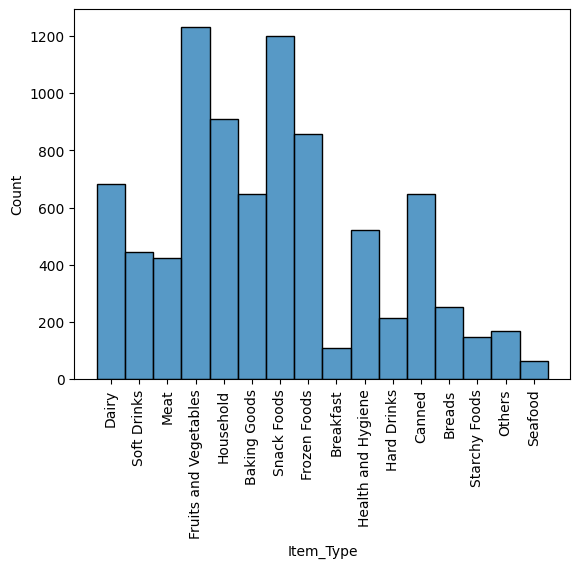

In [54]:
ax = sns.histplot(data=df, x="Item_Type")
ax.tick_params(axis='x', rotation = 90);

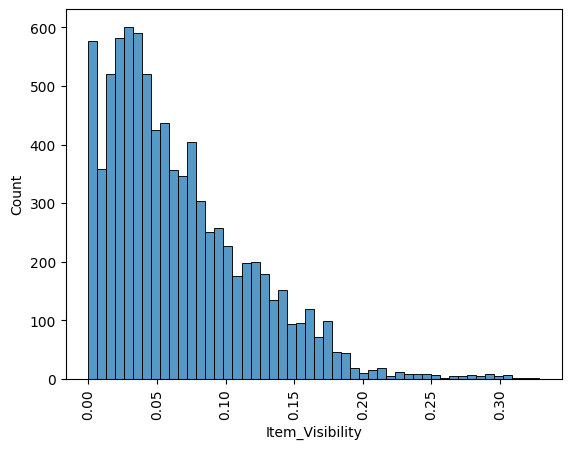

In [55]:
ax = sns.histplot(data=df, x='Item_Visibility')
ax.tick_params(axis='x', rotation = 90);

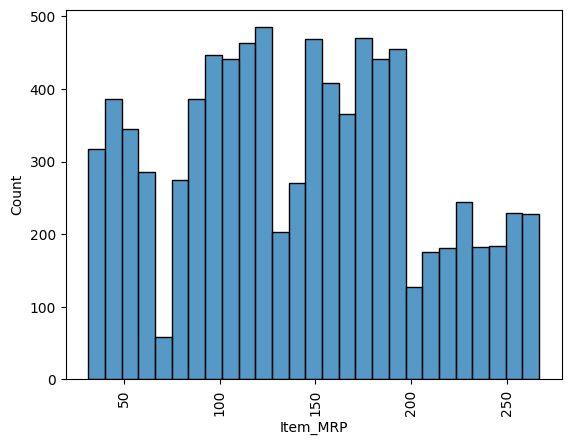

In [56]:
ax = sns.histplot(data=df, x='Item_MRP')
ax.tick_params(axis='x', rotation = 90);

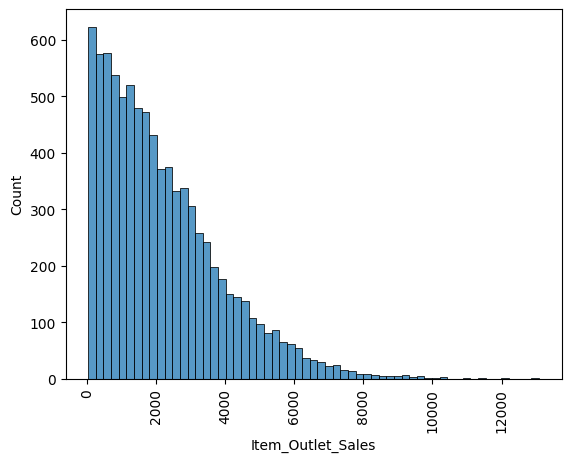

In [57]:
ax = sns.histplot(data=df, x='Item_Outlet_Sales')
ax.tick_params(axis='x', rotation = 90);

Boxplot to view statistical summaries of various features the dataset.


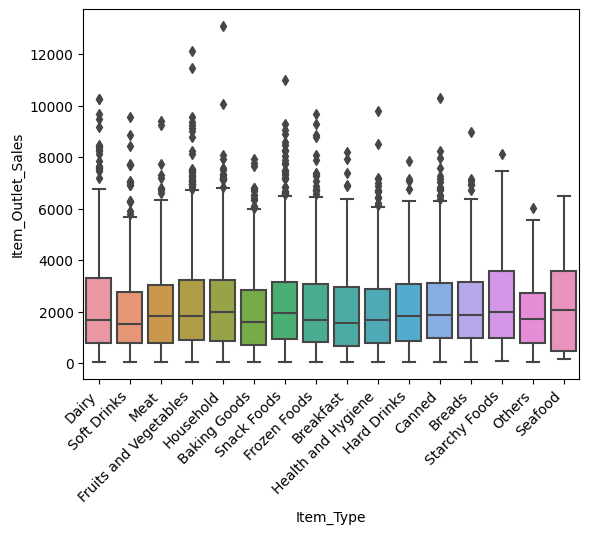

In [58]:
ax = sns.boxplot(data=df, x='Item_Type', y="Item_Outlet_Sales")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

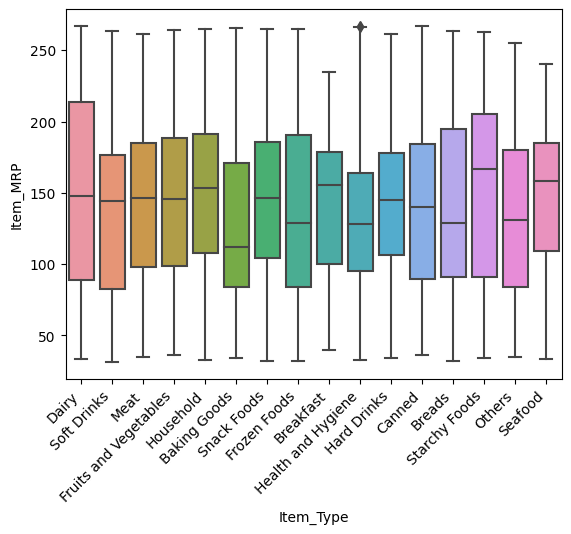

In [59]:
ax = sns.boxplot(data=df, x='Item_Type', y="Item_MRP")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

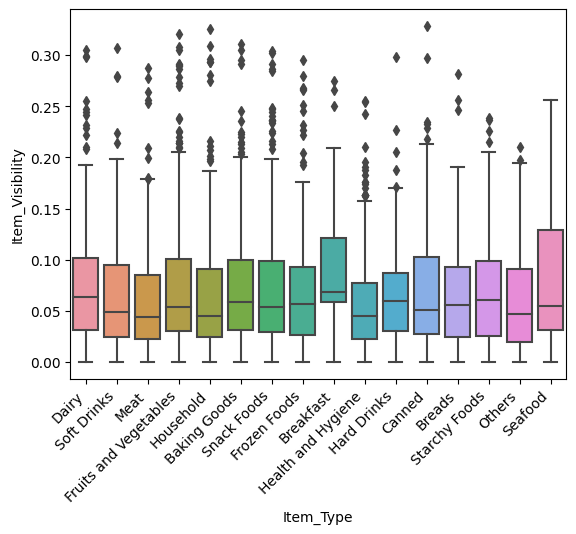

In [60]:
ax = sns.boxplot(data=df, x='Item_Type', y="Item_Visibility")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

Heatmap of the correlation between features.

In [61]:
corr = df.corr(numeric_only = True)
corr.round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.00,-0.01,0.02,0.01,0.01
Item_Visibility,-0.01,1.00,-0.00,-0.07,-0.13
Item_MRP,0.02,-0.00,1.00,0.01,0.57
Outlet_Establishment_Year,0.01,-0.07,0.01,1.00,-0.05
Item_Outlet_Sales,0.01,-0.13,0.57,-0.05,1.00


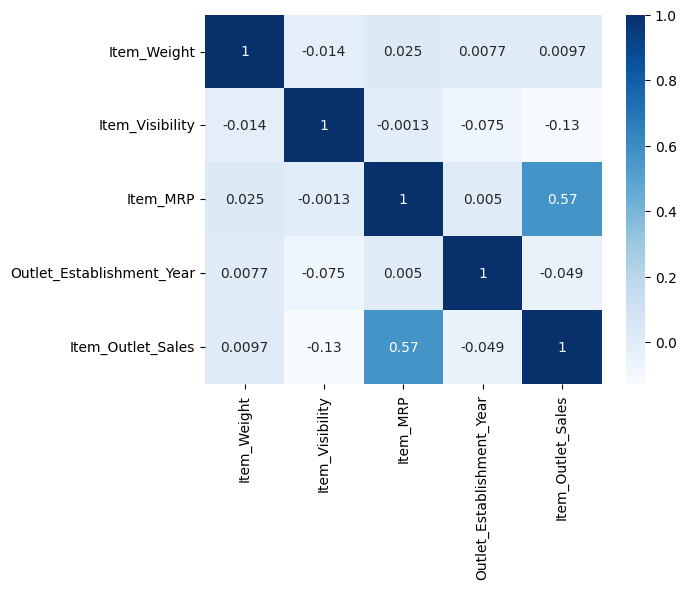

In [62]:
sns.heatmap(corr, cmap = 'Blues', annot = True);

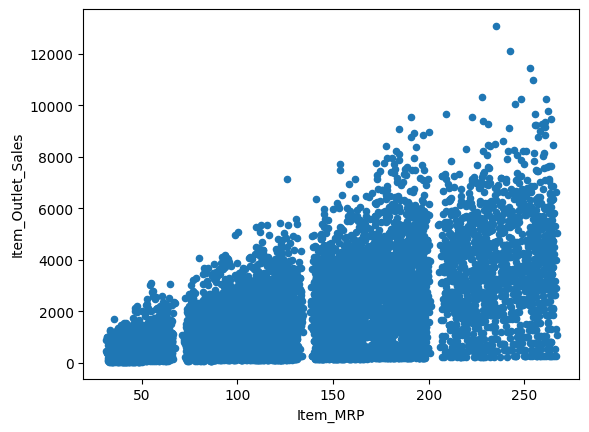

In [63]:
ax = df.plot(kind='scatter', x='Item_MRP', y='Item_Outlet_Sales');

<h2>Explantory Data Analysis</h2>

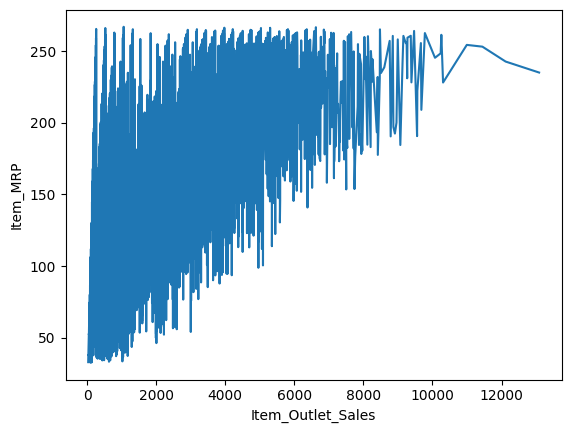

In [64]:
Item_sales_By_MRP = df.groupby('Item_Outlet_Sales').mean()['Item_MRP']
Sales = Item_sales_By_MRP.index

fig, ax = plt.subplots()
ax.plot(Sales, Item_sales_By_MRP);
ax.set(xlabel='Item_Outlet_Sales', ylabel='Item_MRP');

# Inspecting Categorical Columns & Addressing Inconsistent Values

##Train Test Split

In [65]:
target = 'Item_Outlet_Sales'
X = df.drop(columns=[target , 'Item_Outlet_Sales'])
y = df[target]

- Train/test split the data. Please use the random number 42 for consistency.

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

##Column Transformer

Pipelines

In [67]:
ord_cols = ['Outlet_Size']
Size_order = ['Small','Medium','High']
ord_encoder = OrdinalEncoder(categories=[Size_order], handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()
ord_pipe = make_pipeline(ord_encoder, scaler)
ord_tuple = ('ordinal', ord_pipe, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('ordinalencoder',
                  OrdinalEncoder(categories=[['Small', 'Medium', 'High']],
                                 handle_unknown='use_encoded_value',
                                 unknown_value=-1)),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size'])

In [68]:
cat_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
impute_missing = SimpleImputer(strategy='constant',fill_value='MISSING')
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_pipe = make_pipeline(impute_missing, ohe_encoder)
ohe_tuple = ('categorical', ohe_pipe, cat_cols)

In [69]:
num_cols = X_train.select_dtypes('number').columns
mean_imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
numeric_pipe = make_pipeline(mean_imputer, scaler)
num_tuple = ('numeric', numeric_pipe, num_cols)

In [70]:
col_transformer = ColumnTransformer([num_tuple, ohe_tuple, ord_tuple],
                                    verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  O...
                                 Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size'])],
                  verbose_feature_names_out=False)

In [71]:
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  O...
                                 Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size'])],
                  verbose_feature_names_out=False)

In [72]:
X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)

#Modeling

##Liner Regression

In [73]:
linreg = LinearRegression()
linreg_pipe = make_pipeline(col_transformer, linreg)
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 str...
                                                  Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size'])],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [74]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.2f}")
    print(f"- MSE = {mse:,.2f}")
    print(f"- RMSE = {rmse:,.2f}")
    print(f"- R^2 = {r_squared:,.2f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  y_train_pred = reg.predict(X_train)

  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  y_test_pred = reg.predict(X_test)
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    results_df = results_df.set_index('Label')
    results_df.index.name=None
    return results_df.round(2)

In [75]:
evaluate_regression(linreg_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 735.86
- MSE = 971,660.28
- RMSE = 985.73
- R^2 = 0.67

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 220,632,052,952.06
- MSE = 8,630,339,342,030,449,433,116,672.00
- RMSE = 2,937,743,920,431.20
- R^2 = -3,128,093,652,735,880,192.00


##Random Tree

In [76]:
rf = RandomForestRegressor(random_state = 42)
rf_pipe = make_pipeline(col_transformer, rf)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 str...
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [77]:
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 297.22
- MSE = 184,699.97
- RMSE = 429.77
- R^2 = 0.94

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 773.25
- MSE = 1,241,328.37
- RMSE = 1,114.15
- R^2 = 0.55


In [78]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
          'Outlet_Establishment_Year'],
         dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='MISSING',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     O...
                                 

In [ ]:
params = {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[2,3,4],
          'randomforestregressor__max_features':['sqrt','log2',None],
          'randomforestregressor__oob_score':[True,False],
          }

gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, cv = 3, verbose=1)
gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


In [ ]:
gridsearch.best_params_

In [ ]:
best_rf = gridsearch.best_estimator_
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

#Overall Recommendation#

**Tuned (n_estimators) Random Forest Model Observations**

Here, we see the best results as far as the regression metrics and the model's performance.

For the R^2 score 59% of the variance is explained.

For the MAE the testing score is off by about $734.69